# Can Contents Improve Movie Recommendations?

Recommender systems are widely used today to recommend movies, music, news and all kinds of products to website users. In this project, we built three different types of different movie recommender systems and also evaluated their performance. This project focused on how contents of movies can improve the result of the movie recommendation. The content of the project is listed as following:  

- Why Content-Based Recommender
- Preparing the Data
    - Feature Selection
- Building Collaborative Filtering Recommender
- Building Content-Based Recommender
- Building Hybrid Recommender
    - Introduction of Recommender
    - Data Pre-Processing
    - Model Training
- Recommender Evaluation
- Results and Conclusions
- Additional (Interesting) Facts
- Citation
- Appendix

## Why Content-Based Recommender
In one of the class assignment we built a movie recommender using collaborative filtering (CF). It takes the interaction matrix, which consists the records of the ratings of movies by every user. One interesting fact or disadvantage of CF is that it only uses users' ratings as input. This means no matter what you are recommending, such as movies, songs or news, you always use the same method for different products. The intrinsic facts of products, such as the director of the movie or the singer of the song,  are not used in CF. We would like to discover how these intrinsic facts can be used in recommending. 

Collaborative filtering also has has limitations in application. It works well when you have lots of data and the utility matrix is dense. However, it works poorly when the utility matrix is sparse, which could be the case of large product inventory, short-lived products and lots of new users [1]. In those cases, CF performs poorly because many items are rated by users and most users do not rate any items. Content based recommender overcomes this shortcoming. Even if you only have the record of one user buying one item, based on the characteristic (content) of the item, we can recommender similar items to that user. 

In [1]:
# !pip install -q xlrd
# !pip install lightfm

import pandas as pd
import numpy as np
import scipy
from scipy import sparse
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity
from lightfm import LightFM
from lightfm.evaluation import precision_at_k
import requests
from bs4 import BeautifulSoup
import time
import re
import pickle
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import coo_matrix
from scipy.sparse import save_npz
from scipy.sparse import load_npz

/anaconda3/lib/python3.6/site-packages/lightfm/_lightfm_fast.py:9: UserWarning: LightFM was compiled without OpenMP support. Only a single thread will be used.
  warnings.warn('LightFM was compiled without OpenMP support. '


## Preparing the Data 

In our project, we mainly made use of two types of data: 

![](data_intro.jpeg)

1. Ratings records of a user toward different movies he / she has ever watched and rated
2. Movie's attributes including actors, director & screenplay, and summaries

The following parts will give a brief introduction of our steps of data preparation.

### Data Sources

We collected our data from two sources:

1. The ratings records comes from [the MovieLens Dataset](https://grouplens.org/datasets/movielens/). The dataset is pre-processed and stored in `.csv` format.
2. The movies' attributes are scraped from [the Movie Database](https://www.themoviedb.org/?language=en). A sample screenshot of this website is given below:

![](data_scrape_source.jpeg)

### Data Scraping

Given a filtered list of valid movie ids, we scraped the original htmls of each movie and then extracted selected features from them.

Core code blocks are presented below. To run the code from scratch, the complete scripts can be found in the **appendix** section.

In [ ]:
response_dict = {}
error_log = []

mov_TMDB_id_list = mov_TMDB_df["tmdbId"]
mov_TMDB_err_list = []

# scraping original html

counter = 0
for tmdb_id in mov_TMDB_id_list:
    counter += 1
    if counter % 100 == 0:
        print("[PROGRESS] {} / {}".format(counter, len(mov_TMDB_id_list)))

    url = "https://www.themoviedb.org/movie/" + tmdb_id
    response = requests.get(url)
    
    if response.status_code != 200:
        print("    [ERROR LOG] TMDB_ID: {}, Response Code: {}. Drop.".format(tmdb_id, response.status_code))
        error_log.append("TMDB_ID: {}, Response Code: {}. Drop.".format(tmdb_id, response.status_code))
        mov_TMDB_err_list.append(tmdb_id)
    else:
        response_dict[tmdb_id] = response

After we get the html text for each movie, we parse the text and extract selected information from them. We will talk about feature selection right after. Again we only present the core code block here. The complete script can be found in the **appendix** section.

In [ ]:
movie_content = []
mov_TMDB_final_list = []

counter = 0
for tmdb_id in mov_TMDB_valid_list:
    counter += 1
    if counter % 100 == 0:
        print("[PROGRESS] {} / {}".format(counter, len(mov_TMDB_valid_list)))

    try:
        html_text = response_dict[tmdb_id].text
        root = BeautifulSoup(html_text, "html.parser")
        mov_name = root.find("div", class_="title").span.a.h2.string

        mov_lang = ""
        mov_genres = []
        mov_keywords = []
        mov_crew = []
        mov_actors = []
        mov_infos = []

        mov_facts = root.find("section", class_="facts").find_all("p")
        for fact in mov_facts:
            if fact.bdi != None and fact.bdi.string == "Original Language":
                mov_lang = re.sub(r"[,.;@#?!&$ ]+", "_", fact.contents[1].strip().lower())
                mov_infos.append(mov_lang)

        mov_genres_section = root.find("section", class_="genres").find_all("li")
        for genre in mov_genres_section:
            mov_genres.append(re.sub(r"[,.;@#?!&$ ]+", "_", genre.a.string.strip().lower()))
        mov_infos.extend(mov_genres)

        mov_keywords_section = root.find("section", class_="keywords").find_all("li")
        for keyword in mov_keywords_section:
            mov_keywords.append(re.sub(r"[,.;@#?!&$ ]+", "_", keyword.a.string.strip().lower()))
        mov_infos.extend(mov_keywords)

        mov_people_list = root.find("div", class_="header_info").find("ol", class_="people").find_all("a")
        for people in mov_people_list:
            mov_crew.append(re.sub(r"[,.;@#?!&$ ]+", "_", people.string.strip().lower()))
        mov_infos.extend(mov_crew)

        mov_actor_list = root.find("section", class_="top_billed").find_all("li")
        for actor in mov_actor_list:
            mov_actors.append(re.sub(r"[,.;@#?!&$ ]+", "_", actor.p.a.string.strip().lower()))
        mov_infos.extend(mov_actors)

        movie_content.append(" ".join(mov_infos))
        mov_TMDB_final_list.append(tmdb_id)
    except:
        print("    [ERROR LOG] TMDB_ID: {}, unable to parse. Drop.".format(tmdb_id))
        mov_TMDB_err_list.append(tmdb_id)


### Feature Selection

An essential part of our project is to decide which features to use to encode a movie. After careful reasoning and experiments, we chose `actors`, `crews` (director, screenplay, story...), `language`, and `summaries` as our standard features of a movie. 

`Actors` and `crews` are selected because these information typically has great influences on people's decision about whether to watch a movie or not. People tend to have their favorite actors and directors, and they don't want to miss any movie from those favored movie stars.

`Language` tends to be an interesting feature. After `tfidf`, the most frequent value of this feature - 'English' - has limited influence towards our prediction. Other values, however, will pop out if one user watched and highly rated movies with a certain foreign language, e.g., French. In this case, our recommender will tend to recommend movies in French because of this essential feature.

`summaries` are keywords and genres of a movie, which shows some basic characteristic of this movie. We treated summaries as a bag of keywords so that similar movies are easier to be found as 'close' in the feature space.

### Data Processing

After the raw data is ready, we then applied `one-hot encoding`, `tfidf` and `normalization` towards our dataset to get the standard input matrices specified in the **Building Content Based Recommender** section. The matrices we used in our example code are in the following shapes.


In [2]:
interaction_train = scipy.sparse.load_npz('interaction_train.npz')
interaction_test = scipy.sparse.load_npz('interaction_test.npz')
item_features = scipy.sparse.load_npz('item_features.npz')
movie_names = np.load('item_labels.p')
movie_features = np.load('item_features_labels.p')

print(repr(interaction_train))
print(repr(interaction_test))
print(repr(item_features))
print(len(movie_names))
print(len(movie_features))

<671x8954 sparse matrix of type '<class 'numpy.float64'>'
	with 89580 stored elements in COOrdinate format>
<671x8954 sparse matrix of type '<class 'numpy.float64'>'
	with 9954 stored elements in COOrdinate format>
<8954x16674 sparse matrix of type '<class 'numpy.float64'>'
	with 141705 stored elements in Compressed Sparse Row format>
8954
16674


## Building Collaborative Filtering Recommender

Our implementation of Collaborative Filtering is identical to what we've built in the assignment. We used matrix factorization to find two lower rank matrix, U and V. U is a matrix of features for each user and V is a matrix of features for each movie. By taking the dot product of the two matrix, we get the original interaction matrix. In this project we used CF as our baseline model.

In [5]:
# Prepare the data
movies = item_features
ratings_train = interaction_train.toarray()
ratings_test = interaction_test.toarray()

In [3]:
def error(X, U, V):
    """ Compute the mean error of the observed ratings in X and their estimated values. 
        Args: 
            X (numpy 2D array) : a ratings matrix as specified above
            U (numpy 2D array) : a matrix of features for each user
            V (numpy 2D array) : a matrix of features for each movie
        Returns: 
            (float) : the mean squared error of the observed ratings with their estimated values
        """
    W = X > 0
    W = W.astype(np.int)
    
    X_pred = U @ V.T
    error_matrix = W * (X - X_pred)**2
    return error_matrix.sum()/W.sum()


def CF_train(X, X_te, k, U, V, niters=51, lam=10, verbose=False):
    """ Train a collaborative filtering model. 
        Args: 
            X (numpy 2D array) : the training ratings matrix as specified above
            X_te (numpy 2D array) : the testing ratings matrix as specified above
            k (int) : the number of features use in the CF model
            U (numpy 2D array) : an initial matrix of features for each user
            V (numpy 2D array) : an initial matrix of features for each movie
            niters (int) : number of iterations to run
            lam (float) : regularization parameter
            verbose (boolean) : verbosity flag for printing useful messages
            
        Returns:
            (U,V) : A pair of the resulting learned matrix factorization
    """
    W = X > 0
    W = W.astype(np.int)
    
    for ii in range(niters):
        for i, Wi in enumerate(W):
            j_idx = np.nonzero(Wi)[0]
            U[i] = np.linalg.solve(np.dot(V[j_idx].T, V[j_idx]) + lam * np.eye(k), np.dot(V[j_idx].T, X[i,j_idx].T))
            
        for j, Wj in enumerate(W.T):
            i_idx = np.nonzero(Wj)[0]
            V[j] = np.linalg.solve(np.dot(U[i_idx].T, U[i_idx]) + lam * np.eye(k),
                                     np.dot(U[i_idx].T, X[i_idx, j]))
#         print('ii', ii)
        if (verbose and (ii % 5 == 0)):
            print('Iter:', ii)
            print('Train Error:', error(X, U, V))
            print('Test Error:', error(X_te, U, V))
            print('---------------')
    
    return (U,V)

In [8]:
# Train CF using k = 5, get trained U and V
k = 5
init_U = np.ones((ratings_train.shape[0],k))
init_V = np.ones((ratings_train.shape[1],k))
trained_U,trained_V = CF_train(ratings_train, ratings_test, k, init_U, init_V, verbose=False)

## Building Content Based Recommender
The content based recommender uses the characteristics of a movie and a user's previous rating to recommend movies to the users.   
The input of this algorithm contains two matrices:  
*   A item-features matrix, whose dimension is $n\times k$. It represents $n$ movies with $k$ features for each movie. 
*   A user-item interaction matrix, whose dimension is $m \times n$. It represents $m$ users with their ratings to $n$ movies. 

The output of this algorithm is a user-feature matrix, whose dimension is $n \times k$. It can be though as a user-profile matrix. Each user is represented with a $k$ dimensional feature vector.  


The algorithm works this way:
```
For each user:  
Element-wise multiply the rating for one movie with the feature vector of the movie. This gives us a new movie-feature matrix ($m \times k$) for that user.    
Sum over all the movies for that user. This returns a $1\times k$ feature vector for that user.  
Calculate the cosine similarity of the user with every movies in the database.  
Recommend the top 10 movies that has the greatest cosine similarity.   
```
Let's use an example to see how this algorithm works intuitively. Suppose we have a user who rated five movies. Three of them is acted by Angelina Jolie and the user likes all the three, so the ratings are positive. Two of them is acted by Robert Downey Jr. and the user dislike the movie, so the ratings are negative. The cosine similarity between the user and movies acted by Jolie would be higher than that between the user and movies acted by Downey.

![](algorithm illustration.png)

The process of this algorithm is illustrated in the figure above. Using the real dataset, we found that some users tend to give higher scores, while others tend to give lower socores. We standardized ratings for each users by subtracting the mean rating, so that for every user, there are some movies they like a lot and some movies they do not like that much. We only want to recommend the movies that is rated above the user's average. Inspired from nlp and document processing, we also processed the features of the movies using tf-idf, so that common features are lower weighted and unique features are more weighted for the prediction.


In [9]:
def standardize_ratings(ratings):
    """ This function standardizes each row of the inputing matrix by subtracting mean of the row.
        Note: when standardizing, only the nonzero elements are counted.
    
        Args: 
            ratings (Numpy 2D array m*n) : The original ratings matrix, whose ratings range from 1-5.
        
        Returns:
            (standardized_ratings, num_watched_movie, avg_rating) : dimensions of the returns are (m*n), (m,), (m,) 
           
    """
    num_watched_movie = np.count_nonzero(ratings, axis=1)
    avg_ratings = ratings.sum(axis=1) / num_watched_movie
    sdd_ratings = np.subtract(ratings, avg_ratings.reshape(-1,1), where=(ratings!=0))
    
    return sdd_ratings, num_watched_movie, avg_ratings

In [10]:
def build_user_profile(movies, train_ratings):
    """ 
        This function returns user profile for all the users if the dataset is small.
    """
    num_users = train_ratings.shape[0]
    num_movies = train_ratings.shape[1]

    num_watched_movies = np.count_nonzero(train_ratings,axis=1).reshape(-1,1)
        
    if not scipy.sparse.issparse(movies):
        movies = np.repeat(movies.reshape(1,movies.shape[0],movies.shape[1]), num_users, axis=0)
        train_ratings = train_ratings.reshape(train_ratings.shape[0], -1, 1)

        user_profile = (train_ratings * movies).sum(axis=1) / num_watched_movies
        
        return user_profile
    else:
        print('movies matrix is not dense')
        return None
   

In [11]:
def get_1user_profile(useridx, ratings_train, movies):
    """This function build the user profile for one user"""
    user_rating = ratings_train[useridx].reshape(-1,1)
    user_profile = movies.multiply(user_rating).sum(axis=0)
    return np.array(user_profile)

def predict_1user_movies(useridx, movieidx, movies, ratings_train):
    """This function calculate the the cosine similarity between one user and a list of movies"""
    user_profile = get_1user_profile(useridx, ratings_train, movies)
    return cosine_similarity(user_profile, movies[movieidx])[0]

In [14]:
# Example User
userid = 425
watched_movieidx = ratings_train[userid].nonzero()[0]
test_movieidx = ratings_test[userid].nonzero()[0]
test_movie_names = [movie_names[idx] for idx in test_movieidx]

#     print('Watched Movie: ')
#     print([movie_names[idx] for idx in watched_movieidx])

#     print('Top 10 Features: ')
#     user_profile = get_1user_profile(userid, ratings_train, movies)[0]
#     print( [movie_features[idx] for idx in np.argsort(user_profile)[::-1][:10]]  )

print('Top 10 Movies (Predicted)')
rating_pred = predict_1user_movies(userid, test_movieidx, movies, ratings_train)
print([movie_names[idx] for rating, idx in sorted(zip(rating_pred, test_movieidx))[::-1][:10]])

print('Top 10 Movies (Actual)')
rating_true = ratings_test[userid, test_movieidx]
print([movie_names[idx] for rating, idx in sorted(zip(rating_true, test_movieidx))[::-1][:10]])

print('Top 5 Movies To recommend')
rating_reco = predict_1user_movies(userid, range(movies.shape[0]), movies, ratings_train)
print([movie_names[idx] for rating, idx in sorted(zip(rating_reco, test_movieidx))[::-1][:5]])
print('---------------')

Top 10 Movies (Predicted)
['Pirates of the Caribbean: The Curse of the Black Pearl (2003)', 'Matrix Reloaded, The (2003)', 'Harry Potter and the Order of the Phoenix (2007)', 'Harry Potter and the Chamber of Secrets (2002)', 'Harry Potter and the Prisoner of Azkaban (2004)', 'Indiana Jones and the Kingdom of the Crystal Skull (2008)', 'Donnie Brasco (1997)', 'E.T. the Extra-Terrestrial (1982)', 'Godfather: Part II, The (1974)', 'V for Vendetta (2006)']
Top 10 Movies (Actual)
['Iron Man (2008)', 'Dark Knight, The (2008)', 'Sweeney Todd: The Demon Barber of Fleet Street (2007)', 'We Own the Night (2007)', 'Constantine (2005)', 'Million Dollar Baby (2004)', 'Pirates of the Caribbean: The Curse of the Black Pearl (2003)', 'Matrix Reloaded, The (2003)', "The Devil's Advocate (1997)", 'Godfather: Part II, The (1974)']
Top 5 Movies To recommend
['Edge of Darkness (2010)', 'Maria Full of Grace (Maria, Llena eres de gracia) (2004)', 'Harry Potter and the Prisoner of Azkaban (2004)', 'Silence of

## Building Hybrid Recommender

In previous sections, we have seen how to use collaborative filtering and content-based recommender separately to make movie recommendations. In this section, we want to take a step further to see how to integrate these two models together so as to make a more informed decision based on both item features and user-item interactions. 

More specifically, we would first introduce a hybrid recommendation model called LightFM which brings together the advantages of both CF and CB models. Then, we would make use of this model in our problem setting and evaluate its performance through comparison with the previous two models. 

### Introduction of LightFM

LightFM is a hybrid model that combines both content-based recommendation and collaborative filtering methods. Essentially, it generalizes the traditional matrix factorization by jointly factorizing the user-item, item-feature and user-item sparse matrix. 

Using latent vectors of low dimentionality to represent each variable and summing them together to represent each user and item, this model reduces the number of parameters to estimate and hence becomes much more efficient than traditional methods. This new latent representation of both users and items can also be viewed as "embeddings", which can be  correlated with Word2Vec methods. To calculate the similarity between user i and item j, we only need to calculate the dot product of their embeddings. 

If you are interested in learning more theoretical details about LightFM model, you can refer to the paper [here](https://arxiv.org/pdf/1507.08439.pdf) written by Maciej Kula. 

### Data Preprocessing


In [15]:
# Data Preprocessing for LigthFM

# horizontally stack identity features for per-item feature estimation
identity_features = sparse.csr_matrix(np.eye(item_features.shape[0]))
item_features_fm = sparse.hstack([item_features, identity_features])

# set positive_threshold >0, others considered as zero
keep = np.where(interaction_train.data > 0)[0]
keep_rows = interaction_train.row[keep]
keep_cols = interaction_train.col[keep]
interaction_train_fm = sparse.csr_matrix((interaction_train.data[keep], (keep_rows, keep_cols)), shape=interaction_train.shape)
print("interaction_train_fm ", repr(interaction_train_fm))

interaction_train_fm  <671x8954 sparse matrix of type '<class 'numpy.float64'>'
	with 48764 stored elements in Compressed Sparse Row format>


### Model Training
For every pass through the data, the model learns to fit the data more and more closely. We use fit_partial to monitor this incremental learning process and visualize this processing by plotting the train/test precision_at_k metric as below. 

Precision_at_k is a built-in evaluation metric of LightFM that calculates how many movies from the top k ranked list has shown in known positives (the ones that user has actually rated). We use this metric for now to observe how the model fits the data through iterations. 

In [16]:
# instantiate and train the model
model = LightFM(loss='warp')
num_iters = 20
test_precision_at_k = []
train_precision_at_k = []
for i in range(num_iters):
    model.fit_partial(interaction_train_fm, item_features=item_features_fm, epochs=1, num_threads=3)
    train_precision_at_k.append(precision_at_k(model, interaction_train_fm, k=10, item_features=item_features_fm).mean())
    test_precision_at_k.append(precision_at_k(model, interaction_test, interaction_train_fm, k=10, item_features=item_features_fm).mean())

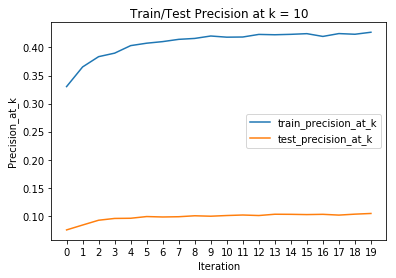

In [17]:
# plot the train/test precision at k = 10 for incremental learning
plt.plot(np.arange(20), train_precision_at_k, label="train_precision_at_k")
plt.plot(np.arange(20), test_precision_at_k,  label="test_precision_at_k")
plt.title("Train/Test Precision at k = 10")
plt.xticks(np.arange(20))
plt.xlabel("Iteration")
plt.ylabel("Precision_at_k")
plt.legend()
plt.show()

We trained the model for 20 iterations with one epoch each time. You can see from the plot above that as the number of iterations increases, the model learns to fit the data better and yields a more precise recommendation strategy.

In the next section, we will evaluate LightFM using modified rank correlation score and compare it with pure collaborative filtering and content-based recommendation model.

## Recommender Evaluations
### Evaluation Metrics
Root mean square error (RMSE) was a popular measurement for recommender systems. It is calculated  by the squre of the difference between a user's real ratings with recommender systems predicted ratings. It requires reommenders' outputs to be real ratings from 1-5 in our case. However, both of our content-based recommender and hybrid recommender's outputs are relative scores from -1 to 1, with 1 means that the user will like the movie with the highest probability. Thus, we created a evaluation metrics to compare the **ranking** between test data (movies) and the output from our recommender.   

| Movie   |      Actual Rank      |   Recommended Rank  |
|:----------:|:-------------:| : ------ :|
|movie1| 1| 1 |
|movie2| 2| 4 |
|movie3| 3| 2 |
|movie4| 4| 3 |
|movie5| 5| 5 | 

One twist of the spearman's rank correlation is that we took the length of the movie list into consideration. This is because the randomness of the test data. In the test data set, the test movies list for some users may contain only 2 movies, while for some other users, the length of the test movie list contains more than 10 movies. We wanted to give recommender a higher score if it can rank 10 movies correctly versus rank 2 movies correctly. Thus the final formula we used for each user is:

$$
Score = length(movies) \times spearmancorr(Actual Rank, Recommened Rank)
$$

For each recommender system, we averaged score over all users.

### Results and Conclusions

In [18]:
# evaluate the trained CF Recommender
def CF_measure_auc(ratings_test, U, V):
    """for each user, measure the auc score on test data, return 1D array of AUC score"""
    X_pred = U @ V.T
    scores = []
    lengths = []
    for user_idx in range(ratings_test.shape[0]):
        if np.count_nonzero(ratings_test[user_idx]) == 0:
            continue
        else:
            movieidx = ratings_test[user_idx].nonzero()[0]
            rating_true = ratings_test[user_idx, movieidx]
            rating_pred = X_pred[user_idx, movieidx]
            if np.unique(rating_true).size == 1 or np.unique(rating_pred).size == 1 :
                continue
            else:
                scores.append(len(rating_true) * stats.spearmanr(rating_true, rating_pred)[0])
    return scores

CF_corr_scores = CF_measure_auc(ratings_test, trained_U, trained_V)
print('The rank correlation test score for Collaborative Filtering Recommender:', np.mean(CF_corr_scores))

The rank correlation test score for Collaborative Filtering Recommender: 4.66560622231


In [19]:
# evaluate the trained CB Recommender
def CB_measure_auc(ratings_test, ratings_train, movies):
    """for each user, measure the auc score on test data, return 1D array of AUC score"""
    scores = []
    lengths = []
    for user_idx in range(ratings_test.shape[0]):
        if np.count_nonzero(ratings_test[user_idx]) == 0:
            continue
        else:
            movieidx = ratings_test[user_idx].nonzero()[0]
            rating_true = ratings_test[user_idx, movieidx]
            rating_pred = predict_1user_movies(user_idx, movieidx, movies, ratings_train)
            if np.unique(rating_true).size == 1 or np.unique(rating_pred).size == 1:
                continue
            else:
                scores.append(len(rating_true) * stats.spearmanr(rating_true, rating_pred)[0])
            
    return scores
  
CB_corr_scores = CB_measure_auc(ratings_test, ratings_train, movies)
print('The rank correlation test score for Content-based Recommender:', np.mean(CB_corr_scores))

The rank correlation test score for Content-based Recommender: 4.84261883379


In [20]:
# evaluate the trained LightFM model
def FM_measure_auc(ratings_test):
    """for each user, measure the auc score on test data, return 1D array of AUC score"""
    scores = []
    lengths = []
    for user_idx in range(ratings_test.shape[0]):
        if np.count_nonzero(ratings_test[user_idx]) == 0:
            continue
        else:
            movieidx = ratings_test[user_idx].nonzero()[1]
            rating_true = np.array(ratings_test[user_idx, movieidx])[0]
            rating_pred = model.predict(user_idx, movieidx, item_features=item_features_fm, num_threads=2)
            if np.unique(rating_true).size == 1 or np.unique(rating_pred).size == 1 :
                continue
            else:
                scores.append(len(rating_true) * stats.spearmanr(rating_true, rating_pred)[0])
    return scores

FM_corr_scores = FM_measure_auc(interaction_test.todense())
print("The rank correlation test score for Hybrid Recommender: ", np.mean(FM_corr_scores))

The rank correlation test score for Hybrid Recommender:  5.50112737795


| | CF | CB | Hybrid |
|:- :| |:----:|:----:|:----:|
|Test Score |4.67| 4.84 | 5.46|


The results of rank correlation test scores are summarized in the table above. As we can see, content-based model achieves a slightly better score than collaborative filtering model. The hybrid model we built outperforms both CF and CB, yielding a better ranking quality regarding recommendation list. 

In our project, we only used a medium size of user-item interaction data, which leads to the sparsity and therefore a relatively poor performance of collaborative filtering. With more dense interaction data, we capture more collaborative information about users' preferences and expect CF to have a better performance in such settings. However, in most real-life cases, we usually cannot expect to have enough data to make effective CF-based recommendations. That's when we want to incorporate content-based strategy and utilize item metadata to make more informed decisions. The hybrid model takes the advantage of both CF and CB, so it is not really surprising to see it achieves the best performance. 

## Additional (Interesting) Facts
With features of all the movies and ratings from the users, our content-based recommender can also find out what features are mostly loved by our users. Would your favourite actors be one of the beloved features? Let's see!

In [21]:
overall_user_profile = np.zeros(item_features.shape[1])
for userid in range(ratings_train.shape[0]):
    overall_user_profile += get_1user_profile(userid, ratings_train, movies)[0]
print('Top 10 beloved movie features:')
print( [movie_features[idx] for idx in np.argsort(overall_user_profile)[::-1][:10]])

Top 10 beloved movie features:
['drama', 'cult_film', 'based_on_novel', 'crime', 'history', 'war', '1940s', 'nazi', 'harrison_ford', 'documentary']


Among all the movie features, drama is the most popular genre. Surprisingly, cult film is the second feature in the list. It's probably because cult films have very specific audience target. Only those who love to watch cult film will rate cult film. Harrison Ford is probably the most popular actors due to his starring roles as Han Solo in the Star Wars film series. 

## Citation
[1] PyDataTV. “Maciej Kula - Hybrid Recommender Systems in Python.” YouTube, YouTube, 26 Mar. 2016, www.youtube.com/watch?v=EgE0DUrYmo8.  
[2] Leskovec, Jure, Anand Rajaraman, and Jeffrey David Ullman. Mining of massive datasets. Cambridge university press, 2014.

## Appendix

### Script for Scraping

#### Get movie list

In [2]:
# data import

data_path = "../Data/ml-latest/"

mov_links_df = pd.read_csv(data_path + "links.csv", dtype='str')
print("num of movies: " + str(mov_links_df.shape[0]))


num of movies: 45843


In [3]:
mov_noTMDB_df = mov_links_df[mov_links_df["tmdbId"].isna()]
mov_withTMDB_df = mov_links_df.dropna()


In [4]:
dup_ids = set(mov_withTMDB_df[mov_withTMDB_df["tmdbId"].duplicated() == True]["tmdbId"])
print("num of duplicated tmdbID: " + str(len(dup_ids)))


num of duplicated tmdbID: 29


In [5]:
mov_dupTMDB_df = mov_withTMDB_df[mov_withTMDB_df["tmdbId"].apply(lambda x:x in dup_ids)]
mov_IMDB_df = pd.concat([mov_dupTMDB_df, mov_noTMDB_df])
mov_TMDB_df = mov_withTMDB_df[mov_withTMDB_df["tmdbId"].apply(lambda x:x not in dup_ids)]

print("num of rows using imdbID: " + str(mov_IMDB_df.shape[0]))
print("num of rows using tmdbID: " + str(mov_TMDB_df.shape[0]))


num of rows using imdbID: 278
num of rows using tmdbID: 45565


#### Scraping from tmdb

In [6]:
response_dict = {}
error_log = []

mov_TMDB_id_list = mov_TMDB_df["tmdbId"]
mov_TMDB_err_list = []


In [ ]:
# scraping original html

counter = 0
for tmdb_id in mov_TMDB_id_list:
    counter += 1
    if counter % 100 == 0:
        print("[PROGRESS] {} / {}".format(counter, len(mov_TMDB_id_list)))

    url = "https://www.themoviedb.org/movie/" + tmdb_id
    response = requests.get(url)
    
    if response.status_code != 200:
        print("    [ERROR LOG] TMDB_ID: {}, Response Code: {}. Drop.".format(tmdb_id, response.status_code))
        error_log.append("    [ERROR LOG] TMDB_ID: {}, Response Code: {}. Drop.".format(tmdb_id, response.status_code))
        mov_TMDB_err_list.append(tmdb_id)
    else:
        response_dict[tmdb_id] = response


In [16]:
print(len(response_dict))

tmp_response_list = list(response_dict.items())

with open('response_dict_1.p', 'wb') as fp:
    pickle.dump(tmp_response_list[:20000], fp)

with open('response_dict_2.p', 'wb') as fp:
    pickle.dump(tmp_response_list[20000:40000], fp)

with open('response_dict_3.p', 'wb') as fp:
    pickle.dump(tmp_response_list[40000:], fp)

# with open('scraping_error_log.p', 'wb') as fp:
#     pickle.dump(error_log, fp)
    

45100


In [17]:
del tmp_response_list

In [18]:
# with open('response_dict.p', 'rb') as fp:
#     loaded_response_dict = pickle.load(fp)


In [19]:
err_id_set = set(mov_TMDB_err_list)
mov_TMDB_valid_list = [tmdb_id for tmdb_id in mov_TMDB_id_list if tmdb_id not in err_id_set]

# check the mov_TMDB_valid_list == response_dict.keys()
print("length of mov_TMDB_valid_list: {}".format(len(mov_TMDB_valid_list)))
print("length of response_dict: {}".format(len(list(response_dict.keys()))))
print("difference between the two: ")
print(set(mov_TMDB_valid_list) - set(list(response_dict.keys())))


length of mov_TMDB_valid_list: 45100
length of response_dict: 45100
difference between the two: 
set()


In [ ]:
movie_content = []
mov_TMDB_final_list = []

counter = 0
for tmdb_id in mov_TMDB_valid_list:
    counter += 1
    if counter % 100 == 0:
        print("[PROGRESS] {} / {}".format(counter, len(mov_TMDB_valid_list)))

    try:
        html_text = response_dict[tmdb_id].text
        root = BeautifulSoup(html_text, "html.parser")
        mov_name = root.find("div", class_="title").span.a.h2.string

        mov_lang = ""
        mov_genres = []
        mov_keywords = []
        mov_crew = []
        mov_actors = []
        mov_infos = []

        mov_facts = root.find("section", class_="facts").find_all("p")
        for fact in mov_facts:
            if fact.bdi != None and fact.bdi.string == "Original Language":
                mov_lang = re.sub(r"[,.;@#?!&$ ]+", "_", fact.contents[1].strip().lower())
                mov_infos.append(mov_lang)

        mov_genres_section = root.find("section", class_="genres").find_all("li")
        for genre in mov_genres_section:
            mov_genres.append(re.sub(r"[,.;@#?!&$ ]+", "_", genre.a.string.strip().lower()))
        mov_infos.extend(mov_genres)

        mov_keywords_section = root.find("section", class_="keywords").find_all("li")
        for keyword in mov_keywords_section:
            mov_keywords.append(re.sub(r"[,.;@#?!&$ ]+", "_", keyword.a.string.strip().lower()))
        mov_infos.extend(mov_keywords)

        mov_people_list = root.find("div", class_="header_info").find("ol", class_="people").find_all("a")
        for people in mov_people_list:
            mov_crew.append(re.sub(r"[,.;@#?!&$ ]+", "_", people.string.strip().lower()))
        mov_infos.extend(mov_crew)

        mov_actor_list = root.find("section", class_="top_billed").find_all("li")
        for actor in mov_actor_list:
            mov_actors.append(re.sub(r"[,.;@#?!&$ ]+", "_", actor.p.a.string.strip().lower()))
        mov_infos.extend(mov_actors)

        movie_content.append(" ".join(mov_infos))
        mov_TMDB_final_list.append(tmdb_id)
    except:
        print("    [ERROR LOG] TMDB_ID: {}, unable to parse. Drop.".format(tmdb_id))
        mov_TMDB_err_list.append(tmdb_id)


In [25]:
with open('movie_content.p', 'wb') as fp:
    pickle.dump(movie_content, fp)

with open('TMDB_final_list.p', 'wb') as fp:
    pickle.dump(mov_TMDB_final_list, fp)
    

In [26]:
tfidf = TfidfVectorizer(min_df=2)
item_features = tfidf.fit_transform(movie_content)
item_features_dict = tfidf.vocabulary_


In [27]:
from scipy.sparse import save_npz
from scipy.sparse import load_npz

save_npz('item_features.npz', item_features)
# load_npz('item_features.npz')


In [30]:
print("item_features matrix shape: ")
print(item_features.shape)
print(len(item_features_dict))

item_features matrix shape: 
(42908, 52255)
52255


In [41]:
# item_features_labels
item_features_labels = []
for feature, pos in sorted(item_features_dict.items(), key=lambda x:x[1]):
    item_features_labels.append(feature)

with open('item_features_labels.p', 'wb') as fp:
    pickle.dump(item_features_labels, fp)
with open('item_features_dict.p', 'wb') as fp:
    pickle.dump(item_features_dict, fp)


### Generating Rating Matrix

In [1]:
USE_SMALL_DATASET = True


#### Get movie list

In [2]:
# data import

if USE_SMALL_DATASET:
    data_path = "../Data/ml-latest-small/"
else:
    data_path = "../Data/ml-latest/"

mov_links_df = pd.read_csv(data_path + "links.csv", dtype='str')
print("num of movies: " + str(mov_links_df.shape[0]))

ratings_df = pd.read_csv(data_path + "ratings.csv")
print("num of ratings: " + str(ratings_df.shape[0]))
ratings_df["movieId"] = ratings_df["movieId"].astype("str")
ratings_df["userId"] = ratings_df["userId"].astype("str")
ratings_df.drop("timestamp", axis=1, inplace=True)

movie_df = pd.read_csv(data_path + "movies.csv", dtype='str')


num of movies: 9125
num of ratings: 100004


In [3]:
# generating tmdb_id -> movie_id mapping

tmdb_to_movie_id = {}

for index, row in mov_links_df.iterrows():
    if (row["tmdbId"] is not None):
        tmdb_to_movie_id[row["tmdbId"]] = row["movieId"]

small_tmdb_set = set(tmdb_to_movie_id.keys())
        
del mov_links_df

In [4]:
with open("movie_content.p", "rb") as fp:
    movie_content_large = pickle.load(fp)

with open("TMDB_final_list.p", "rb") as fp:
    tmdb_id_list_large = pickle.load(fp)

movie_id_list = []
tmdb_id_list = []
movie_content = []

for index, tmdb_id in enumerate(tmdb_id_list_large):
    if not tmdb_id in small_tmdb_set:
        continue
    tmdb_id_list.append(tmdb_id)
    movie_id_list.append(tmdb_to_movie_id[tmdb_id])
    movie_content.append(movie_content_large[index])


In [5]:
tfidf = TfidfVectorizer(min_df=2)
item_features = tfidf.fit_transform(movie_content)
item_features_dict = tfidf.vocabulary_


In [6]:
if USE_SMALL_DATASET:
    save_npz('./small/item_features.npz', item_features)
else:
    save_npz('./item_features.npz', item_features)
# load_npz('item_features.npz')


In [7]:
# item_features_labels

item_features_labels = []
for feature, pos in sorted(item_features_dict.items(), key=lambda x:x[1]):
    item_features_labels.append(feature)

if USE_SMALL_DATASET:
    with open('./small/item_features_labels.p', 'wb') as fp:
        pickle.dump(item_features_labels, fp)
    with open('./small/item_features_dict.p', 'wb') as fp:
        pickle.dump(item_features_dict, fp)
else:
    with open('./item_features_labels.p', 'wb') as fp:
        pickle.dump(item_features_labels, fp)
    with open('./item_features_dict.p', 'wb') as fp:
        pickle.dump(item_features_dict, fp)


In [8]:
# get the movie list (in order) used in the item_features matrix

movie_id_set = set(movie_id_list)
movie_id_dict = {movie_id:i for i, movie_id in enumerate(movie_id_list)}


In [9]:
# only leave records that have a corresponding movie record

sub_ratings = ratings_df[ratings_df["movieId"].apply(lambda x:x in movie_id_set)]
sub_ratings.reset_index(inplace=True)

# del ratings_df

In [11]:
usr_list = sub_ratings["userId"].unique()
usr_dict = {userID : i for i, userID in enumerate(usr_list)}
usr_num = len(usr_list)

mov_list = movie_id_list
mov_dict = movie_id_dict
mov_num = len(mov_list)

movie_names = [list(movie_df[movie_df['movieId'] == movie_id]["title"])[0] for movie_id in mov_list]

print("length of movie_name: " + str(len(movie_names)))

del movie_df

length of movie_name: 8954


In [12]:
if USE_SMALL_DATASET:
    with open('./small/item_labels.p', 'wb') as fp:
        pickle.dump(movie_names, fp)
else:
    with open('./item_labels.p', 'wb') as fp:
        pickle.dump(movie_names, fp)    
    

In [13]:
# training and testing split
P = np.random.permutation(len(sub_ratings))
entry_num = len(P)
train_num = int(np.floor(9 * entry_num / 10))
train_set = sub_ratings.loc[P[:train_num]]
test_set = sub_ratings.loc[P[train_num:]]

print("train set shape: ")
print(train_set.shape)

print("test set shape: ")
print(test_set.shape)


train set shape: 
(89580, 4)
test set shape: 
(9954, 4)


In [14]:
# calculate sum and frequency for each people. For Normalization!!!
user_rating_stat = {}

for index, row in sub_ratings.iterrows():
    user_id = row["userId"]
    if user_id in user_rating_stat:
        user_rating_stat[user_id]["ratings"] += row["rating"]
        user_rating_stat[user_id]["freq"] += 1
    else:
        user_rating_stat[user_id] = {"ratings": row["rating"], "freq": 1}


In [15]:
counter = 0
rows = []
cols = []
data = []
# compute training matrix
for index, row in train_set.iterrows():
    counter += 1
    if counter % 100000 == 0:
        print("[PROGRESS] {} / {}".format(counter, train_set.shape[0]))

    rows.append(usr_dict[row["userId"]])
    cols.append(mov_dict[row["movieId"]])
    data.append(row["rating"] - (user_rating_stat[row["userId"]]["ratings"] / user_rating_stat[row["userId"]]["freq"]))

X_tr = coo_matrix((data, (rows, cols)), shape=(usr_num, mov_num))

if USE_SMALL_DATASET:
    save_npz('./small/interaction_train.npz', X_tr)
else:
    save_npz('./interaction_train.npz', X_tr)


In [16]:
counter = 0
rows = []
cols = []
data = []
# compute testing matrix
for index, row in test_set.iterrows():
    counter += 1
    if counter % 100000 == 0:
        print("[PROGRESS] {} / {}".format(counter, test_set.shape[0]))

    rows.append(usr_dict[row["userId"]])
    cols.append(mov_dict[row["movieId"]])
    data.append(row["rating"] - (user_rating_stat[row["userId"]]["ratings"] / user_rating_stat[row["userId"]]["freq"]))

X_te = coo_matrix((data, (rows, cols)), shape=(usr_num, mov_num))

if USE_SMALL_DATASET:
    save_npz('./small/interaction_test.npz', X_te)
else:
    save_npz('./interaction_test.npz', X_te)


In [17]:
print("item_features matrix shape: ")
print(item_features.shape)
print()
print("interaction matrix shape: ")
print(X_tr.shape)
print()
print("item_features_labels length: ")
print(len(item_features_labels))
print()
print("item_labels length: ")
print(len(movie_names))
print()


item_features matrix shape: 
(8954, 16674)

interaction matrix shape: 
(671, 8954)

item_features_labels length: 
16674

item_labels length: 
8954

